# <p style="text-align: center;">EE 379K: Data Science Lab</p>
# <p style="text-align: center;">Lab 6 - 10/16/17</p>
## <p style="text-align: center;">Rachel Chen and Kevin Yee</p>
### <p style="text-align: center;"> rjc2737 and kjy252</p>

#Problem 1 
In this problem we will use synthetic data sets to explore the bias-variance tradeoffincurred by using regularization.

* Generate data of the form: 
$$ y = X\beta + \epsilon $$ 

where X is an n x p matrix where n = 51, p = 50, and each $X_{ij} \sim N(0,1)$. Also, generate the noise according to $\epsilon_i \sim N(0,1/4)$. Let $\beta$ be the all ones vector for simplicity.

By repeatedly doing the experiment and generating fresh data (fresh X, and y, and hence $\epsilon$ but keeping $\beta$ fixed, you will estimate many diffferent solutions, $\hat{\beta}$. Estimate the mean and variance of $\hat{\beta}$. Note that $\hat{\beta}$ is a vector, so for this exercise simply estimate the variance of a single component.


* Use ridge regression i.e. $l_2$ regularization. Vary the regularization coefficient $\lambda = 0.01, 0.1, 1, 10, 100$ and repeat the above experiment. What do you observe? As you increase $\lambda$ is the model becoming more simple or more complex? As you increase $\lambda$ is performance becoming better or worse? 

#Answer

In [60]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [50]:
#generate data
X = np.random.normal(0,1, size = (51,50))
e = np.random.normal(0,.25)
beta = np.ones((51,50))

#Create OLS unbiased model to estiamte beta hat 
linear = LinearRegression()

#Compute y
y = X.dot(beta.T) + e

#Compute coefficient with Linear regression model: 
linear.fit(X,y)

#TODO: Compute this multiple times like the question asked

print "Ordinary Least Squares:"
print " Mean of beta hat using OLS: " + str(np.mean(linear.coef_))
print " Variance of beta hat using OLS: " + str(np.var(linear.coef_))

alphas = [0.01, 0.1, 1, 10, 100]
print "\nRidge Regression:"
for alpha in alphas:
    ridge = Ridge(alpha = alpha).fit(X,y)
    print
    print "lambda = " + str(alpha)
    print " Mean of beta hat using Ridge: " + str(np.mean(ridge.coef_))
    print " Variance of beta hat using Ridge: "+ str(np.var(ridge.coef_))

Ordinary Least Squares:
 Mean of beta hat using OLS: 1.0
 Variance of beta hat using OLS: 4.57140882599e-29

Ridge Regression:

lambda = 0.01
 Mean of beta hat using Ridge: 0.998308649716
 Variance of beta hat using Ridge: 8.93286151433e-05

lambda = 0.1
 Mean of beta hat using Ridge: 0.986906650762
 Variance of beta hat using Ridge: 0.00201580971811

lambda = 1
 Mean of beta hat using Ridge: 0.921195552172
 Variance of beta hat using Ridge: 0.0168474736669

lambda = 10
 Mean of beta hat using Ridge: 0.69349038346
 Variance of beta hat using Ridge: 0.067716896546

lambda = 100
 Mean of beta hat using Ridge: 0.297628850281
 Variance of beta hat using Ridge: 0.0401563797212


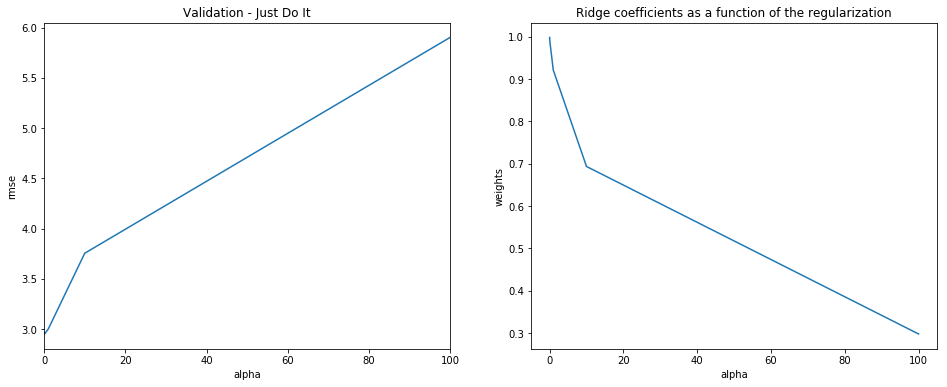

In [58]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


alphas = [0.01, 0.1, 1, 10, 100]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

coefs = [Ridge(alpha = alpha).fit(X,y).coef_.mean() for alpha in alphas]

plt.figure(figsize=(16,6))
plt.subplot(121)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.subplot(122)
plt.plot(alphas,coefs)
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')


From the figure comparing alpha and rmse, the model is getting increasingly worse as alpha is increasing

From the figure comparing alpha and weights, the model is getting increasingly simpler as the weights of $\hat{\beta}$ decreases


# Problem 2 
Problem 9 from Chapter 6.
(Predicting  the  number  of  applications  in  College)  Note  that  you  will  have  to  read  about  PCR(Principal Components Regression) and PLS (Partial Least Squares ) in the book, since we did not discuss these in class.

![](http://i.markdownnotes.com/image_7m46Jzg.png)

#Answer

In [102]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [89]:
college = pd.read_csv("Data/College.csv")

#split data up
y = college.Apps
X = college.drop('Apps',axis = 1)
X['Private'] = X['Private'].replace('Yes',1).replace('No',0)
X = X.loc[:, "Private":]
X.head()

#split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=20)


#iniatlize models 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ols = LinearRegression()
ridgeCV = RidgeCV(alphas=alphas, cv=10)
lassoCV = LassoCV(alphas=alphas, cv=10, max_iter=10000)

# Least Squares
ols.fit(X_train, y_train)
olsmse = mean_squared_error(y_test, ols.predict(X_test))

print "OLS Linear Regression MSE: " + str(olsmse)

# RidgeCV 
ridgeCV.fit(X_train, y_train)
ridgemse = mean_squared_error(y_test, ridgeCV.predict(X_test))
                  
print "Ridge Regression MSE: " + str(ridgemse)
# LassoCV
lassoCV.fit(X_train, y_train)
lassomse = mean_squared_error(y_test, lassoCV.predict(X_test))
                  
print "Lasso Regression MSE: " + str(lassomse)
print "Lasso, Non Zero Coefficients", len(lassoCV.coef_.nonzero()[0])

OLS Linear Regression MSE: 788016.339525
Ridge Regression MSE: 788849.335783
Lasso Regression MSE: 789339.4189
Lasso, Non Zero Coefficients 17


Number of Components:  1 MSE Score:  15928570.8251
Number of Components:  2 MSE Score:  4665468.39867
Number of Components:  3 MSE Score:  4652824.66434
Number of Components:  4 MSE Score:  2961593.97084
Number of Components:  5 MSE Score:  2965287.52316
Number of Components:  6 MSE Score:  2931619.8343
Number of Components:  7 MSE Score:  2784060.38728
Number of Components:  8 MSE Score:  2748117.24749
Number of Components:  9 MSE Score:  2663349.37745
Number of Components:  10 MSE Score:  2670187.70934
Number of Components:  11 MSE Score:  2684571.47268
Number of Components:  12 MSE Score:  2692537.94755
Number of Components:  13 MSE Score:  2703360.07636
Number of Components:  14 MSE Score:  2702642.79043
Number of Components:  15 MSE Score:  1998509.91364
Number of Components:  16 MSE Score:  1527014.99208
PCA MSE: 7274329.85079


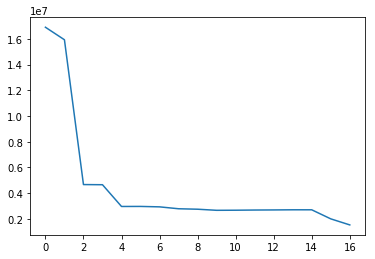

In [115]:
#PCR
pca = PCA()
pc_train_x = pca.fit_transform(scale(X_train))
pc_test_x = pca.fit_transform(scale(X_test))

mse = []
linear = LinearRegression()

#Find number of components using cross validation mse scores
#Zero Components
mse.append(np.mean(-1 * cross_val_score(linear, np.ones((len(pc_train_x), 1)),
                                        y_train, cv=10, scoring='neg_mean_squared_error')))

#One to Ten Components
for i in range(1, len(X_train.columns)):
    mse.append(np.mean(-cross_val_score(linear, pc_train_x[:, :i], y_train, cv=10,
                                    scoring='neg_mean_squared_error')))
    print "Number of Components: ", i, "MSE Score: ", mse[i]

plt.plot(mse)

linear.fit(pc_train_x, y_train)
pcamse = mean_squared_error(y_test, linear.predict(pc_test_x))

print "PCA MSE: " + str(pcamse)

The best component occurs when we use all 17 feautures in our prediction. This is agreed upon with Lasso Regression.
The MSE using PCA is 7274329.85079

# Problem 3

![](http://i.markdownnotes.com/image_9kryzAh.png)


# Problem 4

**Ordinary Least Squares:**

$$min_\beta: ||X\beta -y||_2^2 = \sum(X_i\beta-y_i)^2$$
1. Vector Notation. Derive and Set to Zero.
$$2X^T(X\beta-y) = 0 $$ 


2. $$2X^TX\beta-2X^Ty =0$$
$$~$$
$$2X^TX\beta - 2X^Ty = 0 $$
$$~$$
$$ X^T X \beta = X^T y $$
$$~$$
$$ \hat{\beta} = (X^TX)^-1X^Ty$$


**Ridge Regression:**
$$min_\beta: ||X\beta -y||_2^2 + \lambda ||\beta||^2_2= \sum(X_i\beta-y_i)^2 + \lambda \sum \beta_i^2$$

1. Make Vector Notation, Derive and set to zero

$$2X^T(X\beta-y) + 2\lambda \beta = 0 $$ 

 
2. $$2X^TX\beta-2X^Ty + 2\lambda\beta =0$$
$$~$$
$$ X^T X \beta + \lambda\beta = X^T y $$
$$~$$
$$(X^TX + \lambda I)\beta = X^Ty$$
$$~$$
$$\hat{\beta} = (X^TX + \lambda I)^{-1}X^Ty$$